In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

from matplotlib.dates import DateFormatter

# Update rcParams to set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [2]:
# define experiment to be preprocessed
experiment_series = "2024_04_03"

### Tidy simulations of the infection model

In [3]:
infection_model_simulation_path = os.path.join("../simulation_output/infection_model", experiment_series)
infection_model_preprocessed_path = os.path.join("preprocessed_data/infection_model", experiment_series)

In [4]:
# create directories if they do not already exist
os.makedirs(infection_model_preprocessed_path, exist_ok=True)

In [20]:
df = pd.read_csv(os.path.join(infection_model_simulation_path, f"{2}_console_output.csv"), sep=",", index_col=False)

In [21]:
df.head()

,Unnamed: 0,ts,numS,numE,numI_ns,numI_sy,numI_sev,numI_cri,numR,numD
0,1,0.000000,845,4,2,2,0,0,0,0
1,2,0.041667,844,5,2,2,0,0,0,0
2,3,0.083333,844,5,2,2,0,0,0,0
3,4,0.125000,844,5,2,2,0,0,0,0
4,5,0.166667,844,5,2,2,0,0,0,0


In [22]:
"""
Based on the console output of the MEmilio simulation, we can get the prevalence of the disease over time.
The prevalence is the sum of the number of exposed, carriers, symptomatic, severe, and critical cases.
Note that in the newest version of MEmilio, the console output is not automatically stored anymore,
hence, the console output was created manually based on the infection paths. 
"""
def tidy_console_output(memilio_output_path, memilio_id):
    df = pd.read_csv(os.path.join(memilio_output_path, f"{memilio_id}_console_output.csv"), sep=",", index_col=False)
    df["time"] = pd.to_datetime(df["ts"], unit="d", origin=pd.Timestamp('2024-01-01'))
    df["memilio_id"] = memilio_id
    df = df[["time", "memilio_id", "numS","numE","numI_ns","numI_sy","numI_sev","numI_cri","numR","numD"]]
    df.columns = [ "time", "memilio_id", "S", "E", "C", "I", "I_s", "I_c", "R", "D"]
    df["I_total"] = df["E"] +  df["C"] + df["I_s"] + df["I_c"] + df["I"] # total cases (i.e. prevalence) are asymptomatic + severe + critical + mild with symptoms (C is carrier)
    return df


In [23]:
df_res = [tidy_console_output(infection_model_simulation_path, memilio_id) for memilio_id in range(1, 251)]
df_res = pd.concat(df_res)
df_res.to_csv(os.path.join(infection_model_preprocessed_path, "console_output_summarized.csv"), index=False)

### Additional preprocessing 

Note that a tidied version of output.txt is necessary for the plots created in  analysis/2_analyze_one_simulation_in_depth.ipynb

The preprocessing of the data is implemented directly in the mentioned notebook.

### Visualize prevalence

In [24]:
df = pd.read_csv(os.path.join(infection_model_preprocessed_path, f"console_output_summarized.csv"))
df["time"] = pd.to_datetime(df["time"])

/tmp/ipykernel_185707/3968871168.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


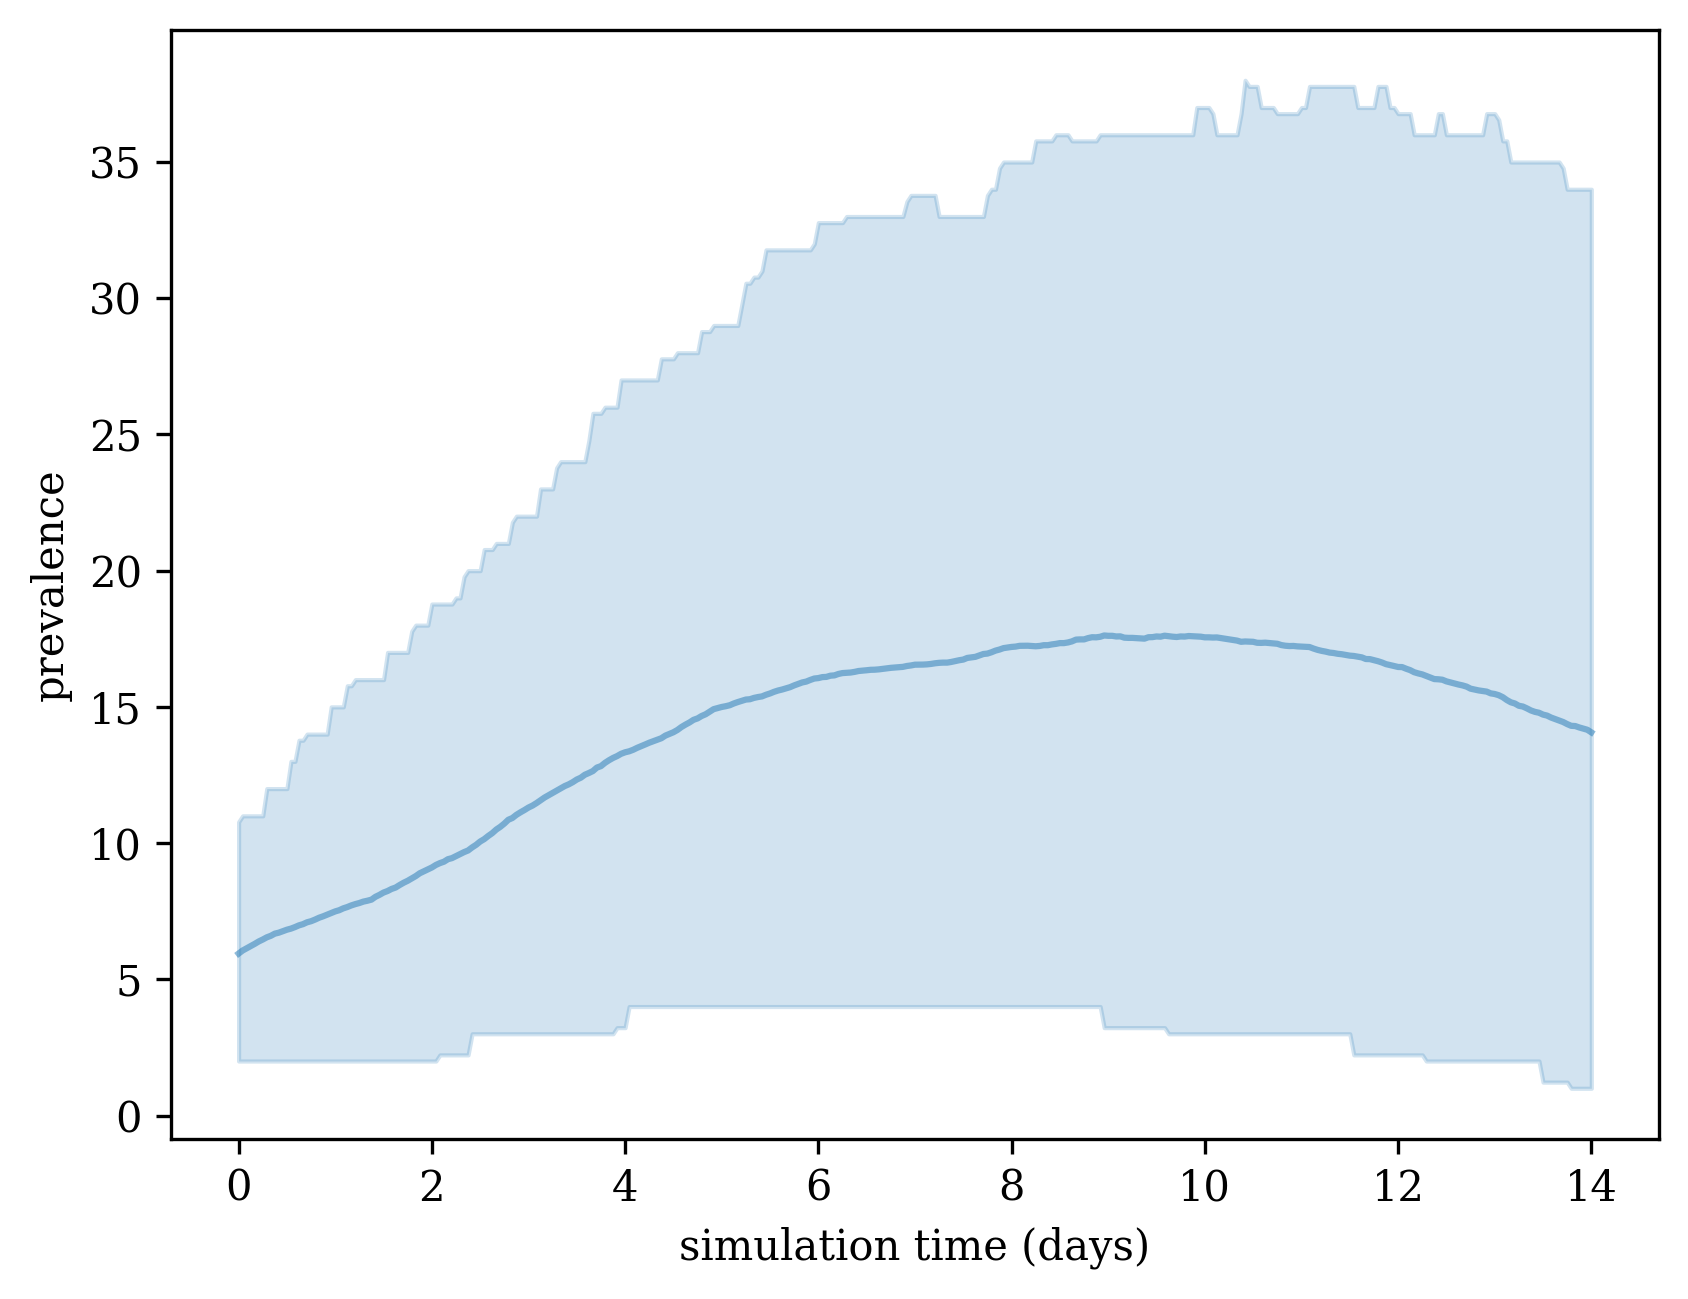

In [26]:
fig, ax = plt.subplots(dpi=300)    
sns.lineplot(data=df, x="time", y="I_total", alpha=0.5, errorbar="pi")
# plt.title('Prevalence - 95% prediction interval of simulation')
plt.xlabel('simulation time (days)')
plt.ylabel('prevalence')
date_form = DateFormatter("%d")
ax.xaxis.set_major_formatter(date_form)
ax.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
os.makedirs("../analysis/plots/infection_model", exist_ok=True)
plt.savefig(os.path.join("../analysis/plots/infection_model", "prevalence.png"))